In [1]:
# Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Loads the data into a dataframe
df = pd.read_csv('./Jan_2019_ontime.csv')
df2 = pd.read_csv('./Jan_2020_ontime.csv')
df.append(df2)
df.shape

(583985, 22)

In [3]:
# Creates a standard baseline binary classifier accuracy by using all of our avaliable data
df.ARR_DEL15.value_counts()

0.0    460741
1.0    105222
Name: ARR_DEL15, dtype: int64

In [4]:
base_accuracy = 460741 / (460741 + 105222)
base_error = 1 - base_accuracy
print('Baseline Accuracy: ', base_accuracy)
print('Baseline Error: ', base_error)

Baseline Accuracy:  0.8140832527921437
Baseline Error:  0.18591674720785634


In [5]:
# Chooses a random sample of 5% of the data to learn on
df = df.sample(frac=0.05)
df = df.drop(['Unnamed: 21', 'OP_UNIQUE_CARRIER', 'ORIGIN_AIRPORT_ID','ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'OP_CARRIER_AIRLINE_ID',
             'DEP_TIME_BLK', 'DEP_DEL15', 'ARR_TIME', 'CANCELLED', 'DIVERTED'], axis=1)
df = df.dropna()
df.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,DEP_TIME,ARR_DEL15,DISTANCE
199718,11,5,YX,N874RW,6041,IND,LGA,1457.0,0.0,660.0
232384,13,7,WN,N295WN,2780,DAL,MEM,1309.0,0.0,423.0
323267,17,4,EV,N860AS,3970,IAD,TYS,1707.0,0.0,420.0
465835,25,5,OH,N209PS,5312,PIA,CLT,1251.0,0.0,607.0
415768,23,3,YV,N931LR,5839,PHX,MRY,1434.0,0.0,598.0


In [6]:
# Turns certain nominally numerical features to categorical ones
X = df.drop('ARR_DEL15', axis=1)
y = df.ARR_DEL15
X.OP_CARRIER_FL_NUM = X.OP_CARRIER_FL_NUM.astype('category')
X.DAY_OF_WEEK = X.DAY_OF_WEEK.astype('category')
X.OP_CARRIER_FL_NUM = X.OP_CARRIER_FL_NUM.astype('category')
X.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,DEP_TIME,DISTANCE
199718,11,5,YX,N874RW,6041,IND,LGA,1457.0,660.0
232384,13,7,WN,N295WN,2780,DAL,MEM,1309.0,423.0
323267,17,4,EV,N860AS,3970,IAD,TYS,1707.0,420.0
465835,25,5,OH,N209PS,5312,PIA,CLT,1251.0,607.0
415768,23,3,YV,N931LR,5839,PHX,MRY,1434.0,598.0


In [7]:
# One-hot-encodes categorical features and standardizes numerical features
X_num = X[['DEP_TIME', 'DISTANCE']]
X_num = (X_num - X_num.mean())/X_num.std()
X_cat = X.drop(['DEP_TIME', 'DISTANCE'], axis=1)
X_cat = pd.get_dummies(X_cat)
X = X_num.join(X_cat)
X.head()

,DEP_TIME,DISTANCE,DAY_OF_MONTH,DAY_OF_WEEK_1,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,DAY_OF_WEEK_6,DAY_OF_WEEK_7,...,DEST_TYS,DEST_UIN,DEST_USA,DEST_VEL,DEST_VLD,DEST_VPS,DEST_WRG,DEST_XNA,DEST_YAK,DEST_YUM
199718,0.256162,-0.245828,11,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
232384,-0.042268,-0.641699,13,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
323267,0.760265,-0.646710,17,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
465835,-0.159220,-0.334356,25,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
415768,0.209784,-0.349389,23,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Creates a logistic regression on the sample and cross-validates categorical features
n_estimators = 100
max_depth = 5
rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
results = cross_validate(rf, X, y, return_train_score=True, n_jobs=-1, error_score='raise')

In [9]:
#Overfitting is impossible, so training and validation scores are nearly identical
randomforest_training_accuracy = results['train_score'].mean()
randomforest_validation_accuracy = results['test_score'].mean()
print(f"Random Forest w/ Cross-Valdation, n_estimators = {n_estimators}, max_depth = {max_depth}:")
print("Training accuracy:", randomforest_training_accuracy)
print("Validation accuracy:", randomforest_validation_accuracy)

Random Forest w/ Cross-Valdation, n_estimators = 100, max_depth = 5:
Training accuracy: 0.8147336420719027
Validation accuracy: 0.8147336423752751


In [12]:
rf.fit(X, y)
fI = pd.Series(rf.feature_importances_,index=X.columns)

<AxesSubplot:>

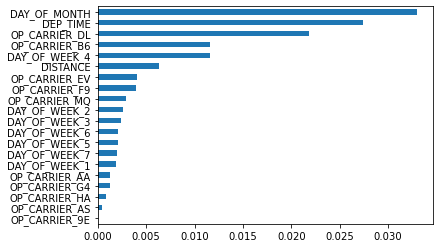

In [15]:
fI.iloc[:20].sort_values().plot.barh()

In [16]:
fI.iloc[:20].sum()

0.13955104599108556

In [27]:
delays = df[df.ARR_DEL15 == 1].OP_CARRIER.value_counts()
delays

WN    865
OO    698
AA    697
DL    475
UA    428
B6    297
MQ    292
YX    269
9E    195
AS    184
OH    165
YV    163
EV    149
F9    118
NK    113
G4     86
HA     47
Name: OP_CARRIER, dtype: int64

In [28]:
flights = df.OP_CARRIER.value_counts()
flights

WN    5490
AA    3825
DL    3569
OO    3093
UA    2313
YX    1194
MQ    1148
B6    1140
OH    1108
AS    1026
9E    1011
YV     836
NK     748
EV     583
F9     495
G4     356
HA     354
Name: OP_CARRIER, dtype: int64

In [29]:
(delays/flights).sort_values(ascending=False)

B6    0.260526
EV    0.255575
MQ    0.254355
G4    0.241573
F9    0.238384
OO    0.225671
YX    0.225293
YV    0.194976
9E    0.192878
UA    0.185041
AA    0.182222
AS    0.179337
WN    0.157559
NK    0.151070
OH    0.148917
DL    0.133091
HA    0.132768
Name: OP_CARRIER, dtype: float64